# Improving *in vitro* using *in vivo* data

The focus of this notebook is to start a fresh outline the whole journey as clearly as can be. Only the relevant sections of the thesis are included.

Some of the main requirements to do this are:
* The modified Perl code used to incorporate in vivo information
* The helper scripts used for counting and data conversion
* The kmer counts previously generated:
 - Counts in human genome
 - Count in DNase data
 - Frequency difference of that count
* Then we can directly create the motifs and test how they are performing

Some action points related to this chapter:
* Transform de Bruijn with dn-hg
* A background noise correction
    * Re-rank with k-mer frequency count difference (hg-dn, considered as noise)
    * Jiang approach

### Requirements:
1. The original Seed and Wobble algorithms from http://the_brain.bwh.harvard.edu/PBMAnalysisSuite/index.html
2. A modified version of the algorithm to take in k-mer frequency counts from http://www.bioinf.ict.ru.ac.za/counts_SnW
3. An executable motif algorithm baded on Gibbs sampling from "http://thebrain.bwh.harvard.edu/hierarchicalANOVA/"

In [4]:
import os
import glob

import pandas as pd
import seaborn as sns

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

### Import MARSTools for evaluations

In [2]:
BASE_DIR = "/home/ckibet/lustre/PBM_DNase"
posneg_path = "/home/ckibet/lustre/Posneg"
pbm_path = "/home/ckibet/lustre/PBM"
scripts_path = "%s/Scripts" % BASE_DIR

In [3]:
os.chdir("/home/ckibet/lustre")
from MARSTools import Assess_by_score as score
os.chdir(scripts_path)

### Plotting style and figure path

In [5]:
sns.set(style="ticks", context="poster")
figure_path = "Results/Chapter6/Figs"

### Get a list of TFs affected by Sticky k-mers

The Sticky k-mers Identified by Jiang et al and downloadable from: are used . 

In [140]:
pbm_chip = []
pbmchip2name = {}
with open('Data/Pbm_Chip_details.txt') as pbmnchip:
    for line in pbmnchip:
        if line.startswith('Tf_id'):
            continue
        else:
            pbm_chip.append(line.split()[0])
            pbmchip2name[line.split()[0]] = line.split()[1]

#revers the dictornary
name2pbmchip = {v: k for k, v in pbmchip2name.items()}

In [141]:
sticky_tfs = pd.read_table("Data/names.txt", header=None)
tf_list = []
for tf in sticky_tfs[0]:
    chip_list = glob.glob("%s/%s/*" % (posneg_path,tf.capitalize()))
    if len(chip_list) > 0:
        tf_list.append(tf)

## Functions used

In [7]:
revcompl = lambda x: ''.join([{'A':'T','C':'G','G':'C','T':'A'}[B] for B in x][::-1])
def mkdir_p(path):
    import os
    import errno

    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def get_unique(tf):
    import glob
    lests = glob.glob("%s/%s/*" % (pbm_path,tf.capitalize()))
    new = []
    for i in lests:
        main = i.split("_v")[0]
        if main in new:
            continue
        else:
            new.append(main)
    return new

def find_kmers(string, kmer_size):
    kmers = []
    for i in range(0, len(string)-kmer_size+1):
        kmers.append(string[i:i+kmer_size])
    return kmers

def get_kmer_dict(kmerscore, kmer_name):
    """
    Try and make this generalized by checking if the first line has header or not. 
    
    Also, check the number of columns and determine which one contains the E-scores
    """

    test = pd.read_table(kmerscore, index_col="8-mer.1", usecols=["8-mer", "E-score"])

    scoredict  = test.to_dict()["E-score"]
    # with open(kmerscore) as kmers:
    #     print kmerscore
    #     for line in kmers:
    #         ke, rems, val = line.split("\t")
    #
    #         scoredict[ke] = val
    return scoredict, kmer_name

def get_kmer_dict_rev(kmerscore, kmer_name):
    test = pd.read_table(kmerscore, index_col="8-mer", usecols=["8-mer", "E-score"])
    test.fillna(0, inplace=True)
    test2 = pd.read_table(kmerscore, index_col="8-mer.1", usecols=["8-mer.1", "E-score"])
    test2.index.name = "8-mer"
    test2.fillna(0, inplace=True)
    combined = test.append(test2)
    combined_dict = combined.to_dict()["E-score"]

    return combined_dict, kmer_name

def energy_score_kmer(seq,kmerdict,revcompl):
    k_mers=find_kmers(seq,8)
    tot_score = 0
    for kmer in k_mers:
        if kmer in kmerdict:
            score=float(kmerdict[kmer])
        else:
            kmer2=revcompl(kmer)
            score=float(kmerdict[kmer2])
        tot_score+=score
    return tot_score

## 1. Transform deBruijn sequences by scoring

The idea behind this approach is to use the dn-hg frequency counts as a measure of k-mer preference to be found in an open chromatin site. The human genome DNase sites frequency difference is used to transform eh deBruijn sequences. 



In [8]:
mot_path="%s/Results/PBM_Reranked" % BASE_DIR

In [9]:
def run_assess(tf, mot_path="%s/Results/PBM_Reranked" % BASE_DIR):
    """
    A function to evaluate the motifs using energy scoring
    """
    user_motif = "%s/%s/%s.meme" % (mot_path, tf.capitalize(), tf.capitalize())
    chip_list = glob.glob("%s/%s/*" % (posneg_path,tf.capitalize()))
    score.run_all(tf.lower(), 'energyscore', user_motif, chip_list, "%s/%s" % (mot_path, tf.capitalize())) 

In [10]:
def combine_meme(tf, path="%s/Results/PBM_Reranked" % BASE_DIR):
    """
    Within a directory, after a seed and wobble run, 
    combine all meme output into a single file. 
    
    """
    meme_out = "%s/%s/%s.meme" % (path,tf.capitalize(), tf.capitalize())
    if os.path.isfile(meme_out):
        os.remove(meme_out)
    meme_motifs = glob.glob("%s/%s/*meme" % (path,tf.capitalize()))
    
    mot = meme_motifs[0]
    !head -9 {mot} >{meme_out}
    for mot in meme_motifs:
        tots = !wc -l {mot}
        !tail -{int(tots[0].split()[0]) -8} {mot} >>{meme_out}
        
    
def run_SnW_normal(tf):
    """
    Performs a normal Seed and wobble run
    """
    script = "%s/Scripts" % BASE_DIR
    out_dir = "%s/Data/PBM_Reranked/%s" % (BASE_DIR,tf.capitalize())
    res_dir = "%s/Results/PBM_Normal/%s" % (BASE_DIR,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        print v1
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        #!perl {script}/seed_and_wobble_twoarray.pl {v1} {v2} 8 {script}/patterns_8of10.txt {script}/patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_deBruijn
        !python {script}/wobble2meme.py {res_dir}/{probe_n}_deBruijn_8mers_pwm_combined.txt {res_dir}/{probe_n}_deBruijn.uniprobe {res_dir}/{probe_n}_deBruijn.meme {probe_n}_deBruijn
    combine_meme(tf, path="%s/Results/PBM_Normal" % BASE_DIR)
    run_assess(tf, mot_path="%s/Results/PBM_Normal" % BASE_DIR)

In [11]:
def run_SnW_counts(tf, scalled):
    """
    Uses the DN-HG frequency counts transformed using minimum absolute from scikit learn.  
    """
    script = "%sScripts" % BASE_DIR
    out_dir = "%s/Data/PBM_Reranked/%s" % (BASE_DIR,tf.capitalize())
    res_dir = "%s/Results/PBM_PWM/%s" % (BASE_DIR,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        print v1
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        !perl {script}/counts_seed_and_wobble_twoarray.pl {v1} {v2} 8 {script}/patterns_8of10.txt {script}/patterns_4x44k_all_8mer.txt {scalled} {res_dir}/{probe_n}_Counts
        !python {script}/wobble2meme.py {res_dir}/{probe_n}_deBruijn_8mers_pwm_combined.txt {res_dir}/{probe_n}_deBruijn.uniprobe {res_dir}/{probe_n}_deBruijn.meme {probe_n}_deBruijn
    combine_meme(tf, path="%s/Results/PBM_PWM" % BASE_DIR)
    run_assess(tf, mot_path="%s/Results/PBM_PWM" % BASE_DIR)

In [12]:
def run_rerank(tf):
    """
    Takes as input, TF name and per
    """
    out_dir = "%s/Data/PBM_Reranked/%s" % (BASE_DIR,tf.capitalize())
    res_dir = "%s/Results/PBM_PWM/%s" % (BASE_DIR,tf.capitalize())
    script = "%s/Scripts" % BASE_DIR
    mkdir_p(res_dir)
    print res_dir
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        scalled ="Data/hg_dn_backround_noise_minmax.txt"
        
        !perl {scripts_path}/counts_seed_and_wobble_twoarray.pl {v1} {v2} 8 {scripts_path}/patterns_8of10.txt {scripts_path}/patterns_4x44k_all_8mer.txt {scalled} {res_dir}/{probe_n}_Counts

        !perl {scripts_path}/rerank.pl {v1} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v1_reranked.txt
        !perl {scripts_path}/rerank.pl {v2} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v2_reranked.txt
        
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 {scripts_path}/patterns_8of10.txt {scripts_path}/patterns_4x44k_all_8mer.txt {probe_n}
        
        !python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_Counts_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_Counts_reranked.uniprobe {res_dir}/{probe_n}_Counts_reranked.meme {probe_n}_Counts_reranked
    combine_meme(tf, "%s/Results/PBM_PWM" % BASE_DIR)
    run_assess(tf, "%s/Results/PBM_PWM" % BASE_DIR)

#### a) Run the normal analyis to benchmark other iteration against

In [6]:
for tf in tf_list:
    print tf
    run_SnW_normal(tf)

#### b) Run the secondary motifs reranking approach

In [1]:
for tf in tf_list:
    print tf
    run_rerank(tf)

### b) Re-ranking intensity scores

This option uses the preferred $k$-mer information to score sequences and use them to re-weigh the intensity scores. Reranking is then directly followed by a normal seed and wobble run. Besides, at this stage, any algorithm can be used. The central area that needs proper optimisation is the best way of re-weighing the scores. 

In [21]:
def transform_deBruijn(tf, kmerscore):
    """
    Given kmer frequency counts, use the information to tranform the deBruijn 
    intensity scores in a way that would reflect in vivo binding behaviour. 
    TODO: 
    """
    scoredict = get_kmer_dict_rev(kmerscore,"test")[0]
    out_dir = "%s/Data/PBM_Reranked2/%s" % (BASE_DIR,tf.capitalize())
    mkdir_p(out_dir)
    for probe in get_unique(tf):
        for i in range(1,3):
            debru = pd.read_table("%s_v%i_deBruijn.txt" % (probe,i), header=None)
            scored = debru[1].apply(lambda seq: energy_score_kmer(seq[:36],scoredict,revcompl))
            normalized = scored/scored.max()
            #print normalized
            test = pd.DataFrame()
            test = test.append(debru[0]*normalized, ignore_index=True)
            finall = test.append(debru[1]).T
            finall.sort_values(by=0, ascending=False, inplace=True)
            probe_n =probe.split("/")[-1]
            finall.to_csv("%s/%s_v%i_reranked_Hg_dn-less.txt" % (out_dir, probe_n,i), sep="\t", index=None, index_label=None, header=None)

In [24]:
for tf in tf_list:
    kmer_score = "Data/dn_hg_backround_noise_mean_std_maxnormalized_positive.txt"
#test = pd.read_table(kmer_score, index_col="8-mer.1", usecols=["8-mer", "E-score"])
    transform_deBruijn(tf, kmer_score)

### Run normal run on the reweighed intensity files

Having reweighed the intensity file using the preferred $k$-mer information, we perform a normal run

In [25]:
def run_SnW(tf, mot="%s/Data/PBM_Reranked" % BASE_DIR):
    """
    
    """
    out_dir = "%s/%s" % ("%s/Data/PBM_Reranked2" % BASE_DIR,tf.capitalize())
    res_dir = "%s/%s" % (mot,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        probe_n =probe.split("/")[-1]
        v1 = "%s/%s_v%i_reranked_Hg_dn-less.txt" % (out_dir, probe_n,1)
        v2 = "%s/%s_v%i_reranked_Hg_dn-less.txt" % (out_dir, probe_n,2)
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_reranked
        !python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_reranked.uniprobe {res_dir}/{probe_n}_reranked.meme {probe_n}_reranked
    combine_meme(tf,mot)
    run_assess(tf, mot)

#### Transform and model TF specificity

In [2]:
for tf in tf_list:
    transform_deBruijn(tf, kmer_score)
    run_SnW(tf,"%s/Results/PBM_Reranked2" % BASE_DIR)

#### Prepare data for plotting

In [155]:
tf_lists = tf_list[:]
res_list = []
res_list.append("Tf_Name Reweighed Secondary Observed".split())
for tf in tf_lists:
    tf_list = []
    tf_list.append(tf)
    for types in "PBM_PWM PBM_Reranked2 PBM_Normal".split():
        energy = "%s/Results/%s/%s/%s.energy" % (BASE_DIR, types,tf.capitalize(), tf.lower())
        new_test = pd.read_table(energy, index_col="Motif")
        new_test.sort_values("AUC", ascending=False, inplace=True)
        #print new_test["AUC"][0]
        tf_list.append(new_test["AUC"].mean())
    res_list.append(tf_list[:])    

In [156]:
plot_df = pd.DataFrame(res_list[1:],columns=res_list[0]).set_index('Tf_Name')

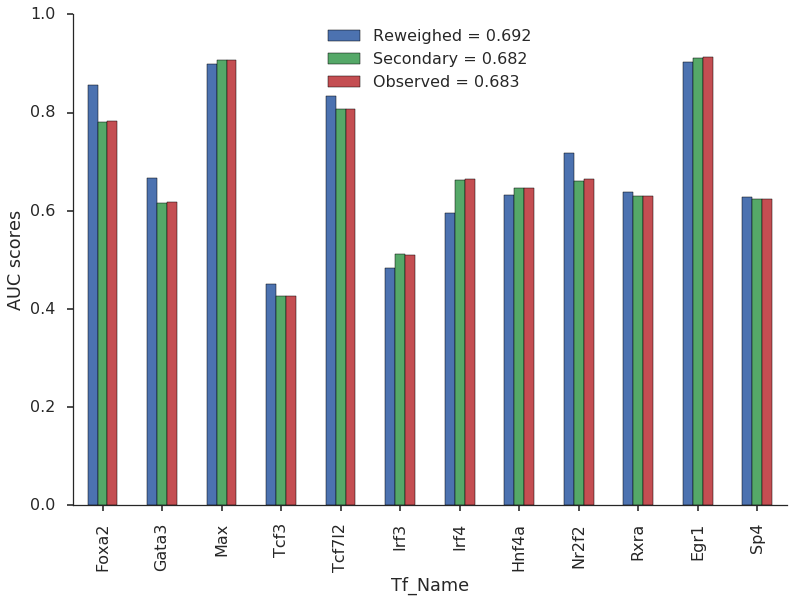

In [157]:
axes = plot_df.plot.bar()
ave_additive = plot_df.mean()
leg = list(plot_df.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_additive[i]))
axes.legend(new_leg,loc='best')
axes.set_ylabel("AUC scores")
sns.despine()
fig = axes.get_figure()
fig.savefig("%s/reranking_kmers.pdf" % figure_path, bbox_inches='tight')

## 2. Using the background correction

This approach uses a modified background correction algorithm by Jiang2013 

In [ ]:
tau_file ="Data/hg_dn_backround_noise3.txt"
tau_2 = pd.read_table(tau_file, header=None)
tau_new = tau_2 * 0.151863
tau_new.to_csv("Data/hg_dn_backround_noise_std.txt", index=False, header=False)

In [15]:
def background_correction(kmer_scores, tau_file, res_dir, out_prefix = "corrected"):
    #kmer_score = pd.read_table(kmer_scores)
    kmer_score = pd.read_table(kmer_scores, header=None,usecols=[0,1,3])
    kmer_score.columns = [["8-mer.1", "8-mer", "E-score"]]
    #kmer_score.index.name = "8-mer"
    tau = pd.read_table(tau_file, header=None)
    x = kmer_score["E-score"]
    suffix = "contig8mers.txt"
    s=0.151863
    m=-0.0196628
    
    c = tau*s
    y = x-c[0]
    corrected_kmers = kmer_score.copy()
    corrected_kmers["E-score"] = y
    #corrected_kmers.T.append(y, ignore_index=True).T
    probe_n = kmer_scores.split("/")[-1].split("_contig8mers")[0]
    
    kmer_scores = "%s/%s" % (res_dir,probe.split("/")[-1])
    
    kmer_score.to_csv(kmer_scores.replace("txt", "observed"), sep="\t", header=True, index=False)
    corrected_kmers.to_csv(kmer_scores.replace("txt", out_prefix), sep="\t", header=True, index=False)
    
    corrected_kmers.sort_values(by="E-score", ascending=False, inplace=True)
    
    corrected_kmers[corrected_kmers["E-score"] >0.35]["8-mer"].to_csv(
        kmer_scores.replace(suffix, "%s_kmers.seq" % out_prefix), sep="\t", header=False, index=False)
    
    kmer_score.sort_values(by="E-score", ascending=False, inplace=True)
    
    
    kmer_score[kmer_score["E-score"] >0.35]["8-mer"].to_csv(kmer_scores.replace(
            suffix,"observed_kmers.seq"), sep="\t", header=False, index=False)
    
    !{script_path}code/pbm.motif -i {kmer_scores.replace(suffix,"observed_kmers.seq")}
    
    
    !{script_path}/pbm.motif -i {kmer_scores.replace(suffix,"%s_kmers.seq" % out_prefix)}
    
    gibbs2meme(probe_n+"_"+out_prefix, kmer_scores.replace(suffix,"%s_kmers.seq.pwm" % out_prefix))
    
    gibbs2meme(probe_n+"_observed", kmer_scores.replace(suffix,"observed_kmers.seq.pwm"))

In [112]:
for tf in combined_list:#[combined_list.index('Gata3'):]: #"Egr1  Esrra  Gata3  Hnf4a  Mafk  Max  Myb  Tcf3".split():
    print tf
    res_dir = "%s/%s" % (pbm_reranked,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_contigmers(tf):
        #probe_n =probe.split("/")[-1]
        kmer_scores = probe
        kmer_scores = "Results/PBM_Reranked/%s/%s_8mers_combined.txt" % (tf,probe_n)
        
        tau_file = "Data/estimated_noise.txt"
        background_correction(kmer_scores, tau_file, res_dir, "sticky")
            
        tau_file ="Data/hg_dn_backround_noise_minabs.txt"
        background_correction(kmer_scores, tau_file, res_dir, "minabs")
        
        tau_file ="Data/hg_dn_backround_noise_std.txt"
        background_correction(kmer_scores, tau_file, res_dir, "scaled")
        
#         tau_file ="Datahg_dn_backround_noise_minmax.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "minmax")
        
#         tau_file = "Data/reweighed.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "corrected")
        
    combine_meme(tf)
    run_assess(tf)
    run_assess_kmer(tf)

In [15]:
combined_list = ['Tcf3', 'Hnf4a', 'Foxa2', 'Irf3', 'Tbp', 'Irf4',
 'Ap2', 'Max', 'Sp4', 'Jund', 'Nr2f2', 'Gata3', 'Arid3a', 'Srf',
 'Tcf7l2', 'Gabp', 'Egr1', 'Rxra', 'Mafk', 'Sp1']

#### Summarize and plot for background correction

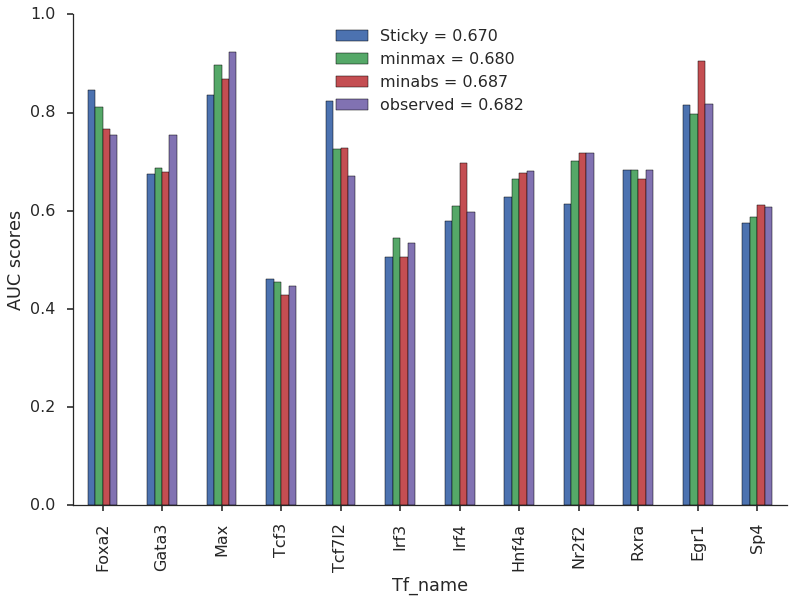

In [146]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed"])
for tf in tf_lists:
    tfs = name2pbmchip[tf]
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results"
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results"
    #test = pd.read_table("%s/%s/%s.energy" % (f1000, tfs,tfs), index_col="Motif")
    energy = "%s/Results/PBM_Reranked/%s/%s.energy" % (BASE_DIR, tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    #scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed]], columns=["Tf_name","Sticky", "minmax","minabs", "observed"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
#plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
axes= plot_df.plot(kind="bar")

#Add values to figure key
ave_additive = plot_df.mean()
leg = list(plot_df.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_additive[i]))
axes.legend(new_leg,loc='best')

sns.despine()

fig = axes.get_figure()
axes.set_ylabel("AUC scores")
fig.savefig("%s/background_correction.png" % figure_path, bbox_inches='tight')

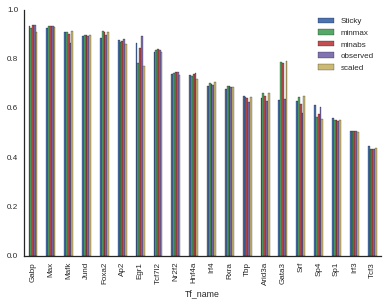

In [21]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed","scaled"])
for tf in combined_list:
    tfs = name2pbmchip[tf]
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.max_kmer" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed,scaled]], columns=["Tf_name","Sticky", "minmax","minabs", "observed","scaled"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")
sns.despine()


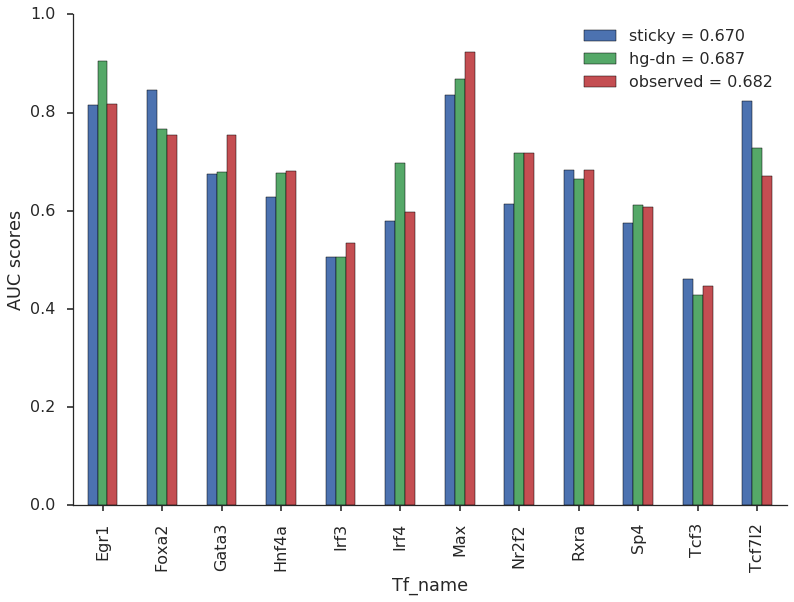

In [133]:
thesis_df = plot_df[["Sticky","minabs","observed"]]

thesis_df.columns = [["sticky","hg-dn","observed"]]
thesis_df = thesis_df.sort_index()
axes = thesis_df.plot.bar()

ave_conserve = thesis_df.mean()
leg = list(thesis_df.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_conserve[i]))
    
axes.legend(new_leg,loc='best')

axes.set_ylabel("")
sns.despine()
axes.set_ylabel("AUC scores")
fig = axes.get_figure()
fig.savefig("%s/background_correction.pdf" % figure_path, bbox_inches='tight')